# Практическая работа: Ансамблевые методы - Bagging и Boosting


## Цели практической работы

В этой практической работе вы:
1. Реализуете различные ансамблевые методы
2. Сравните их производительность на реальных данных
3. Изучите влияние гиперпараметров
4. Проанализируете важность признаков
5. Примените полученные знания к новому датасету

## Структура работы

1. **Подготовка данных**
2. **Реализация Bagging методов**
3. **Реализация Boosting методов** 
4. **Сравнение методов**
5. **Настройка гиперпараметров**
6. **Анализ важности признаков**
7. **Самостоятельное задание**

## Часть 1: Подготовка данных и импорт библиотек

Начнем с импорта необходимых библиотек и загрузки данных для экспериментов.

In [22]:
# Импорт основных библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine, load_breast_cancer, make_classification
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("✅ Библиотеки успешно импортированы!")
print(f"Версия NumPy: {np.__version__}")
print(f"Версия Pandas: {pd.__version__}")

✅ Библиотеки успешно импортированы!
Версия NumPy: 2.3.3
Версия Pandas: 2.3.2


In [23]:
# Импорт ансамблевых методов
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)

# Попробуем импортировать XGBoost (если установлен)
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
    print("✅ XGBoost доступен")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost не установлен. Установите командой: pip install xgboost")

print("✅ Ансамблевые методы импортированы!")

✅ XGBoost доступен
✅ Ансамблевые методы импортированы!


### Задание 1.1: Загрузка и исследование данных

Загрузите датасет Wine и изучите его структуру.

In [24]:
# TODO: Загрузите датасет Wine
wine_data = load_wine()
X_wine, y_wine = wine_data.data, wine_data.target

# TODO: Создайте DataFrame для удобства работы
wine_df = pd.DataFrame(X_wine, columns=wine_data.feature_names)
wine_df['target'] = y_wine
wine_df['target_name'] = [wine_data.target_names[i] for i in y_wine]

# TODO: Выведите основную информацию о датасете
print("Информация о датасете Wine:")
print(f"Размер: {wine_df.shape}")
print(f"Признаки: {len(wine_data.feature_names)}")
print(f"Классы: {wine_data.target_names}")
print(f"Распределение классов:\n{wine_df['target_name'].value_counts()}")

# Покажите первые строки
wine_df.head()

Информация о датасете Wine:
Размер: (178, 15)
Признаки: 13
Классы: ['class_0' 'class_1' 'class_2']
Распределение классов:
target_name
class_1    71
class_0    59
class_2    48
Name: count, dtype: int64


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target,target_name
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,class_0


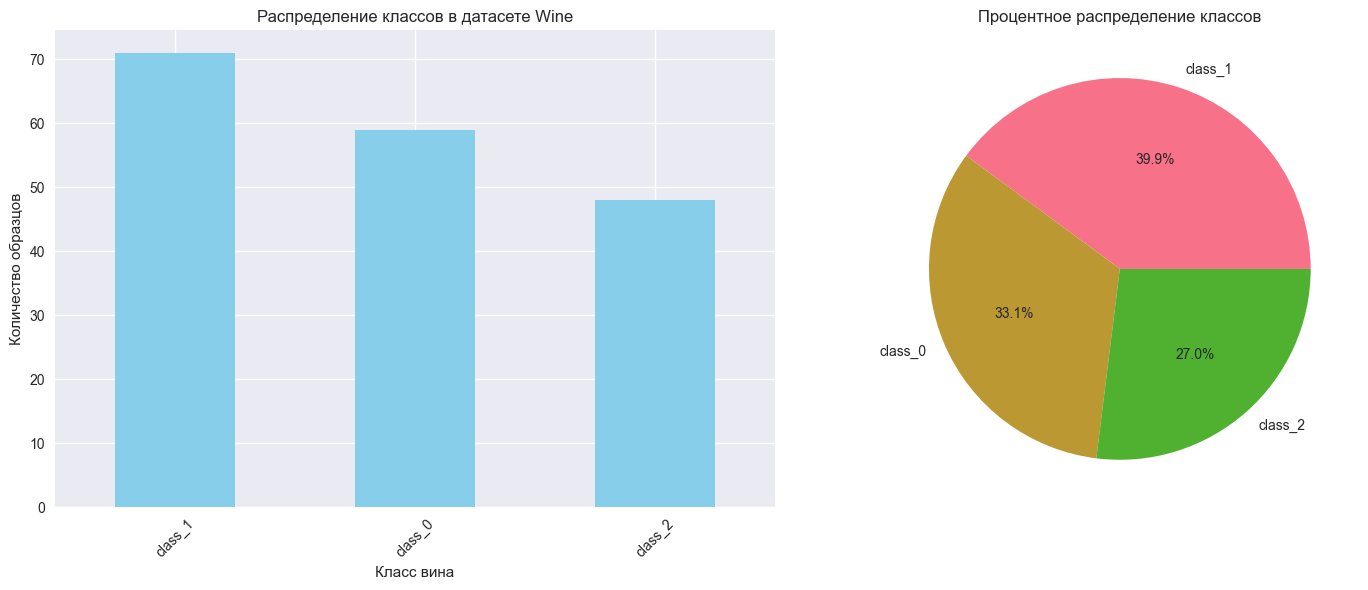


Пропущенные значения: 0


In [25]:
# Визуализация распределения классов
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# TODO: Создайте гистограмму распределения классов
wine_df['target_name'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Распределение классов в датасете Wine')
axes[0].set_xlabel('Класс вина')
axes[0].set_ylabel('Количество образцов')
axes[0].tick_params(axis='x', rotation=45)

# TODO: Создайте круговую диаграмму
wine_df['target_name'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('Процентное распределение классов')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# TODO: Проверьте наличие пропущенных значений
print(f"\nПропущенные значения: {wine_df.isnull().sum().sum()}")

### Задание 1.2: Подготовка данных для обучения

Разделите данные на обучающую и тестовую выборки.

In [26]:
# TODO: Разделите данные на признаки и целевую переменную
X = wine_df.drop(['target', 'target_name'], axis=1)
y = wine_df['target']

# TODO: Разделите на обучающую и тестовую выборки (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

# TODO: Стандартизируйте данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Данные подготовлены и стандартизированы!")

Размер обучающей выборки: (124, 13)
Размер тестовой выборки: (54, 13)
✅ Данные подготовлены и стандартизированы!


## Часть 2: Реализация Bagging методов

Теперь реализуем и сравним различные Bagging методы.

### Задание 2.1: Сравнение одиночного дерева с Bagging

Сравните производительность одиночного дерева решений с Bagging ансамблем.

In [27]:
# TODO: Создайте одиночное дерево решений
single_tree = DecisionTreeClassifier(random_state=42)

# TODO: Создайте Bagging классификатор
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    random_state=42
)

# TODO: Обучите модели
single_tree.fit(X_train_scaled, y_train)
bagging_clf.fit(X_train_scaled, y_train)

# TODO: Сделайте предсказания
single_pred = single_tree.predict(X_test_scaled)
bagging_pred = bagging_clf.predict(X_test_scaled)

# TODO: Вычислите точность
single_accuracy = accuracy_score(y_test, single_pred)
bagging_accuracy = accuracy_score(y_test, bagging_pred)

print("Сравнение производительности:")
print(f"Одиночное дерево решений: {single_accuracy:.4f}")
print(f"Bagging (100 деревьев): {bagging_accuracy:.4f}")
print(f"Улучшение: {bagging_accuracy - single_accuracy:.4f}")

Сравнение производительности:
Одиночное дерево решений: 0.9630
Bagging (100 деревьев): 1.0000
Улучшение: 0.0370


### Задание 2.2: Random Forest и Extra Trees

Реализуйте Random Forest и Extra Trees, сравните их производительность.

In [28]:
# TODO: Создайте Random Forest классификатор
rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# TODO: Создайте Extra Trees классификатор
et_clf = ExtraTreesClassifier(
    n_estimators=100,
    random_state=42
)

# TODO: Обучите модели и оцените их с помощью кросс-валидации
rf_scores = cross_val_score(rf_clf, X_train_scaled, y_train, cv=5, scoring='accuracy')
et_scores = cross_val_score(et_clf, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("Результаты кросс-валидации:")
print(f"Random Forest: {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")
print(f"Extra Trees: {et_scores.mean():.4f} ± {et_scores.std():.4f}")

# TODO: Обучите финальные модели
rf_clf.fit(X_train_scaled, y_train)
et_clf.fit(X_train_scaled, y_train)

# TODO: Сделайте предсказания
rf_pred = rf_clf.predict(X_test_scaled)
et_pred = et_clf.predict(X_test_scaled)

print("\nТочность на тестовой выборке:")
print(f"Random Forest: {accuracy_score(y_test, rf_pred):.4f}")
print(f"Extra Trees: {accuracy_score(y_test, et_pred):.4f}")

Результаты кросс-валидации:
Random Forest: 0.9673 ± 0.0310
Extra Trees: 0.9753 ± 0.0332

Точность на тестовой выборке:
Random Forest: 1.0000
Extra Trees: 1.0000


### Задание 2.3: Анализ важности признаков в Random Forest

Проанализируйте важность признаков и визуализируйте результаты.

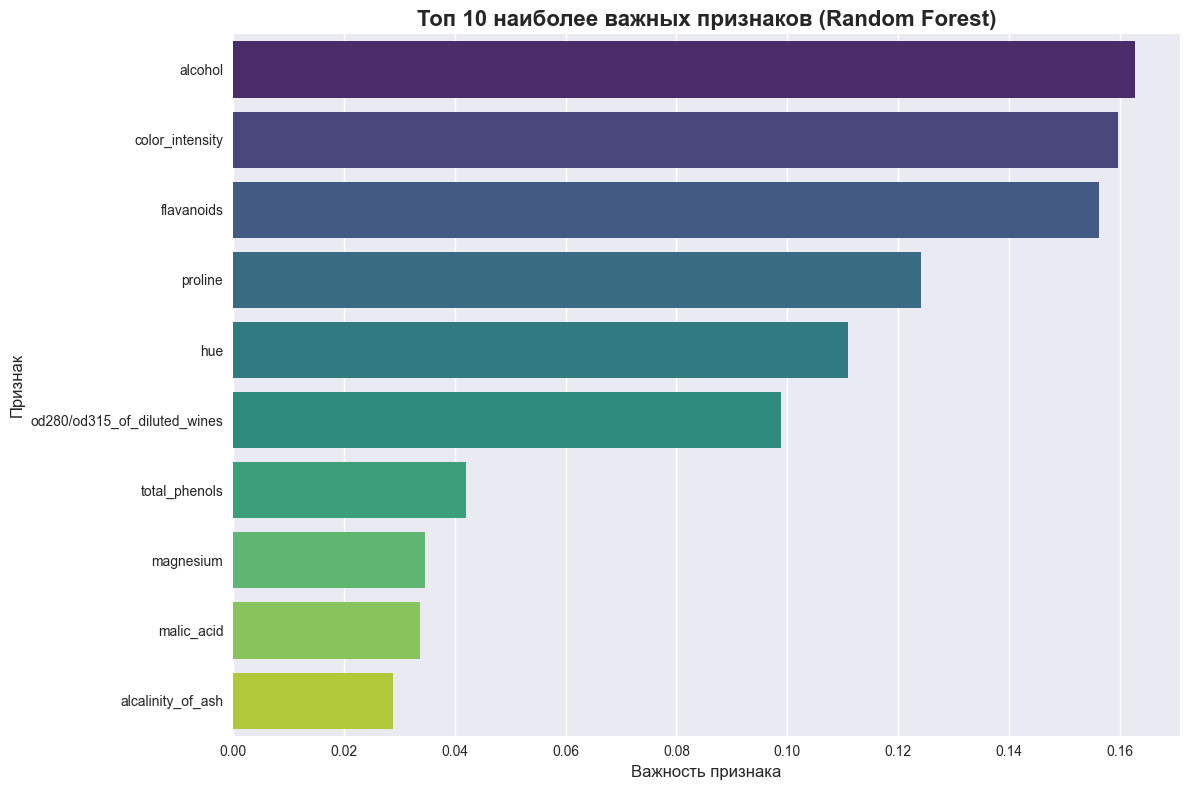

Топ 5 наиболее важных признаков:
alcohol: 0.1627
color_intensity: 0.1597
flavanoids: 0.1563
proline: 0.1241
hue: 0.1110


In [29]:
# TODO: Получите важность признаков из Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

# TODO: Визуализируйте топ-10 наиболее важных признаков
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(10), y='feature', x='importance', palette='viridis')
plt.title('Топ 10 наиболее важных признаков (Random Forest)', fontsize=16, fontweight='bold')
plt.xlabel('Важность признака', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.tight_layout()
plt.show()

# TODO: Выведите топ-5 признаков
print("Топ 5 наиболее важных признаков:")
for i, row in feature_importance.head().iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

## Часть 3: Реализация Boosting методов

Теперь реализуем различные Boosting алгоритмы.

### Задание 3.1: AdaBoost

Реализуйте AdaBoost и исследуйте влияние количества деревьев на производительность.

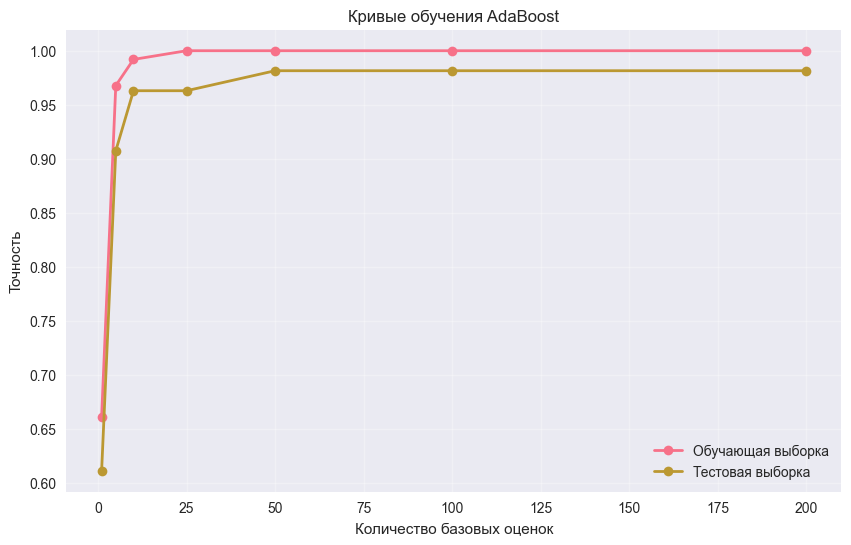

Оптимальное количество деревьев: 50
Лучшая точность: 0.9815


In [30]:
# TODO: Исследуйте влияние количества оценок на производительность AdaBoost
n_estimators_range = [1, 5, 10, 25, 50, 100, 200]
ada_train_scores = []
ada_test_scores = []

for n_est in n_estimators_range:
    # TODO: Создайте AdaBoost классификатор
    ada_clf = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),  # Пни решений
        n_estimators=n_est,
        random_state=42
    )
    
    # TODO: Обучите модель
    ada_clf.fit(X_train_scaled, y_train)
    
    # TODO: Получите точность на обучающей и тестовой выборках
    train_pred = ada_clf.predict(X_train_scaled)
    test_pred = ada_clf.predict(X_test_scaled)
    
    ada_train_scores.append(accuracy_score(y_train, train_pred))
    ada_test_scores.append(accuracy_score(y_test, test_pred))

# TODO: Визуализируйте кривые обучения
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, ada_train_scores, 'o-', label='Обучающая выборка', linewidth=2)
plt.plot(n_estimators_range, ada_test_scores, 'o-', label='Тестовая выборка', linewidth=2)
plt.xlabel('Количество базовых оценок')
plt.ylabel('Точность')
plt.title('Кривые обучения AdaBoost')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Найдите оптимальное количество деревьев
optimal_n = n_estimators_range[np.argmax(ada_test_scores)]
best_score = max(ada_test_scores)
print(f"Оптимальное количество деревьев: {optimal_n}")
print(f"Лучшая точность: {best_score:.4f}")

### Задание 3.2: Gradient Boosting

Реализуйте Gradient Boosting и исследуйте влияние learning rate.

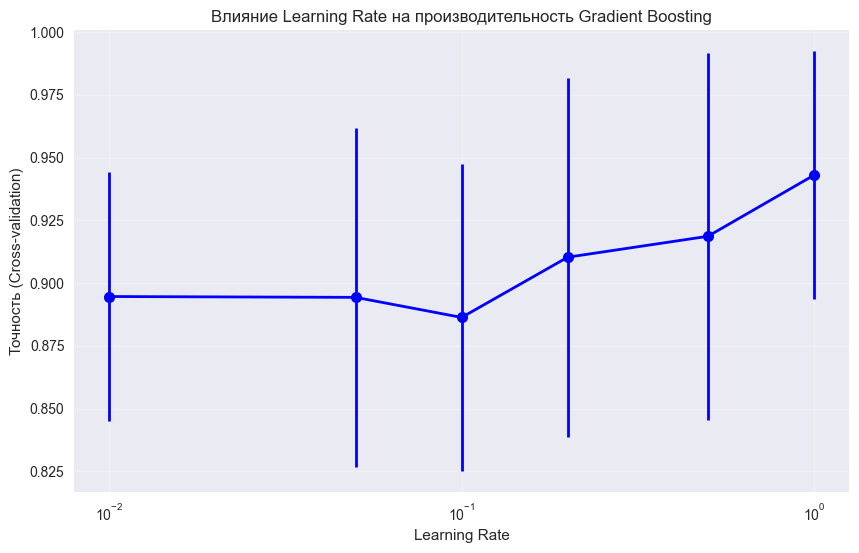

Результаты для различных Learning Rate:
LR = 0.01: 0.8947 ± 0.0496
LR = 0.05: 0.8943 ± 0.0675
LR = 0.1: 0.8863 ± 0.0613
LR = 0.2: 0.9103 ± 0.0716
LR = 0.5: 0.9187 ± 0.0731
LR = 1.0: 0.9430 ± 0.0494


In [31]:
# TODO: Исследуйте влияние learning_rate на Gradient Boosting
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
gb_results = []

for lr in learning_rates:
    # TODO: Создайте Gradient Boosting классификатор
    gb_clf = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=lr,
        max_depth=3,
        random_state=42
    )
    
    # TODO: Оцените с помощью кросс-валидации
    scores = cross_val_score(gb_clf, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    gb_results.append({
        'learning_rate': lr,
        'mean_score': scores.mean(),
        'std_score': scores.std()
    })

# TODO: Визуализируйте результаты
gb_df = pd.DataFrame(gb_results)
plt.figure(figsize=(10, 6))
plt.errorbar(gb_df['learning_rate'], gb_df['mean_score'], 
             yerr=gb_df['std_score'], fmt='bo-', linewidth=2, markersize=8, capsize=5)
plt.xlabel('Learning Rate')
plt.ylabel('Точность (Cross-validation)')
plt.title('Влияние Learning Rate на производительность Gradient Boosting')
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.show()

print("Результаты для различных Learning Rate:")
for result in gb_results:
    print(f"LR = {result['learning_rate']}: {result['mean_score']:.4f} ± {result['std_score']:.4f}")

### Задание 3.3: XGBoost (если доступен)

Если XGBoost установлен, протестируйте его производительность.

In [32]:
if XGBOOST_AVAILABLE:
    # TODO: Создайте XGBoost классификатор
    xgb_clf = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        eval_metric='mlogloss'  # Подавление предупреждений
    )
    
    # TODO: Оцените производительность
    xgb_scores = cross_val_score(xgb_clf, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"XGBoost CV Score: {xgb_scores.mean():.4f} ± {xgb_scores.std():.4f}")
    
    # TODO: Обучите финальную модель
    xgb_clf.fit(X_train_scaled, y_train)
    xgb_pred = xgb_clf.predict(X_test_scaled)
    xgb_accuracy = accuracy_score(y_test, xgb_pred)
    print(f"XGBoost Test Accuracy: {xgb_accuracy:.4f}")
else:
    print("XGBoost не доступен. Установите командой: pip install xgboost")

XGBoost CV Score: 0.9593 ± 0.0264
XGBoost Test Accuracy: 1.0000


## Часть 4: Комплексное сравнение методов

Сравним все реализованные методы на одном датасете.

### Задание 4.1: Сравнение всех методов

Создайте сравнительную таблицу производительности всех методов.

In [33]:
# TODO: Создайте словарь с моделями для сравнения
models = {
    'Single Decision Tree': DecisionTreeClassifier(random_state=42),
    'Bagging': BaggingClassifier(estimator=DecisionTreeClassifier(), 
                               n_estimators=100, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                 n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                                   max_depth=3, random_state=42)
}

# Добавим XGBoost если доступен
if XGBOOST_AVAILABLE:
    models['XGBoost'] = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3,
                                     random_state=42, eval_metric='mlogloss')

# TODO: Оцените все модели
results = []
for name, model in models.items():
    print(f"Обучение {name}...")
    
    # Кросс-валидация
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    # Обучение на полной обучающей выборке
    model.fit(X_train_scaled, y_train)
    test_pred = model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    # Вычисление AUC для многоклассовой классификации
    try:
        test_pred_proba = model.predict_proba(X_test_scaled)
        auc_score = roc_auc_score(y_test, test_pred_proba, multi_class='ovr')
    except:
        auc_score = np.nan
    
    results.append({
        'Model': name,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Test Accuracy': test_accuracy,
        'AUC Score': auc_score
    })

# TODO: Создайте DataFrame с результатами
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test Accuracy', ascending=False)

print("\n" + "="*80)
print("СРАВНЕНИЕ ПРОИЗВОДИТЕЛЬНОСТИ МОДЕЛЕЙ")
print("="*80)
print(results_df.to_string(index=False, float_format='%.4f'))

Обучение Single Decision Tree...
Обучение Bagging...
Обучение Random Forest...
Обучение Extra Trees...
Обучение AdaBoost...
Обучение Gradient Boosting...
Обучение XGBoost...

СРАВНЕНИЕ ПРОИЗВОДИТЕЛЬНОСТИ МОДЕЛЕЙ
               Model  CV Mean  CV Std  Test Accuracy  AUC Score
             Bagging   0.9353  0.0411         1.0000     1.0000
       Random Forest   0.9673  0.0310         1.0000     1.0000
         Extra Trees   0.9753  0.0332         1.0000     1.0000
             XGBoost   0.9593  0.0264         1.0000     1.0000
            AdaBoost   0.9430  0.0424         0.9815     0.9976
Single Decision Tree   0.8620  0.0682         0.9630     0.9695
   Gradient Boosting   0.8863  0.0613         0.9630     0.9985


### Задание 4.2: Визуализация сравнения

Создайте визуализации для сравнения производительности моделей.

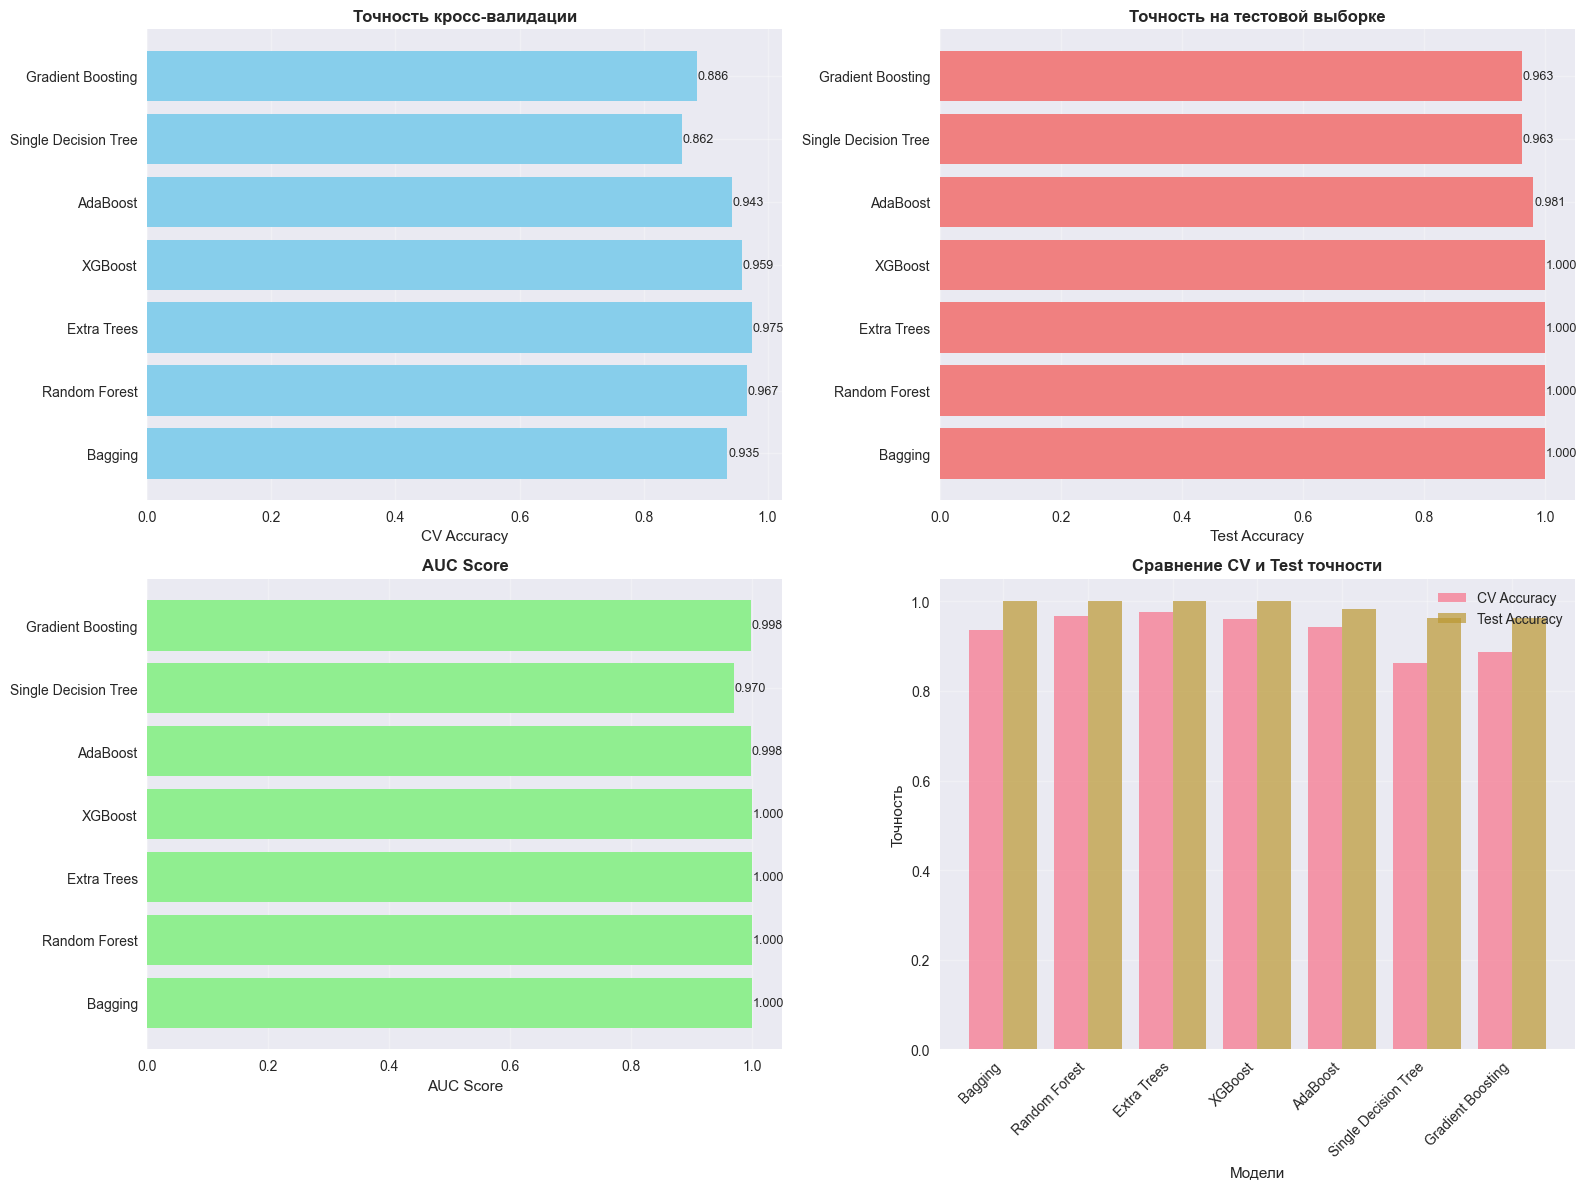

In [34]:
# TODO: Создайте визуализацию сравнения моделей
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: Точность кросс-валидации
ax1 = axes[0, 0]
bars1 = ax1.barh(results_df['Model'], results_df['CV Mean'], color='skyblue')
ax1.set_xlabel('CV Accuracy')
ax1.set_title('Точность кросс-валидации', fontweight='bold')
ax1.grid(True, alpha=0.3)
# Добавим значения на график
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=9)

# График 2: Точность на тестовой выборке
ax2 = axes[0, 1]
bars2 = ax2.barh(results_df['Model'], results_df['Test Accuracy'], color='lightcoral')
ax2.set_xlabel('Test Accuracy')
ax2.set_title('Точность на тестовой выборке', fontweight='bold')
ax2.grid(True, alpha=0.3)
# Добавим значения на график
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=9)

# График 3: AUC Score (если доступен)
ax3 = axes[1, 0]
auc_data = results_df.dropna(subset=['AUC Score'])
if not auc_data.empty:
    bars3 = ax3.barh(auc_data['Model'], auc_data['AUC Score'], color='lightgreen')
    ax3.set_xlabel('AUC Score')
    ax3.set_title('AUC Score', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    for i, bar in enumerate(bars3):
        width = bar.get_width()
        ax3.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                 f'{width:.3f}', ha='left', va='center', fontsize=9)
else:
    ax3.text(0.5, 0.5, 'AUC Score недоступен', ha='center', va='center', transform=ax3.transAxes)

# График 4: Сравнение CV и Test точности
ax4 = axes[1, 1]
x_pos = np.arange(len(results_df))
ax4.bar(x_pos - 0.2, results_df['CV Mean'], 0.4, label='CV Accuracy', alpha=0.7)
ax4.bar(x_pos + 0.2, results_df['Test Accuracy'], 0.4, label='Test Accuracy', alpha=0.7)
ax4.set_xlabel('Модели')
ax4.set_ylabel('Точность')
ax4.set_title('Сравнение CV и Test точности', fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Часть 5: Настройка гиперпараметров

Настроим гиперпараметры для лучшей модели.

### Задание 5.1: GridSearchCV для Random Forest

Используйте GridSearchCV для оптимизации гиперпараметров Random Forest.

In [35]:
# TODO: Определите сетку параметров для Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

print(f"Общее количество комбинаций: {len(rf_param_grid['n_estimators']) * len(rf_param_grid['max_depth']) * len(rf_param_grid['min_samples_split']) * len(rf_param_grid['min_samples_leaf']) * len(rf_param_grid['max_features'])}")

# Упростим сетку для быстрого выполнения
rf_param_grid_simple = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

print(f"Упрощенная сетка: {len(rf_param_grid_simple['n_estimators']) * len(rf_param_grid_simple['max_depth']) * len(rf_param_grid_simple['min_samples_split']) * len(rf_param_grid_simple['max_features'])} комбинаций")

# TODO: Создайте GridSearchCV
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid_simple,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Используем все доступные процессоры
    verbose=1
)

print("Запуск Grid Search для Random Forest...")
# TODO: Выполните поиск
rf_grid_search.fit(X_train_scaled, y_train)

print("\nЛучшие параметры Random Forest:")
print(rf_grid_search.best_params_)
print(f"Лучший CV score: {rf_grid_search.best_score_:.4f}")

# TODO: Оцените оптимизированную модель на тестовой выборке
best_rf = rf_grid_search.best_estimator_
rf_optimized_pred = best_rf.predict(X_test_scaled)
rf_optimized_accuracy = accuracy_score(y_test, rf_optimized_pred)

print(f"Точность оптимизированной модели на тесте: {rf_optimized_accuracy:.4f}")

Общее количество комбинаций: 324
Упрощенная сетка: 24 комбинаций
Запуск Grid Search для Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Лучшие параметры Random Forest:
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
Лучший CV score: 0.9753
Точность оптимизированной модели на тесте: 1.0000


### Задание 5.2: Кривые валидации

Постройте кривые валидации для важных гиперпараметров.

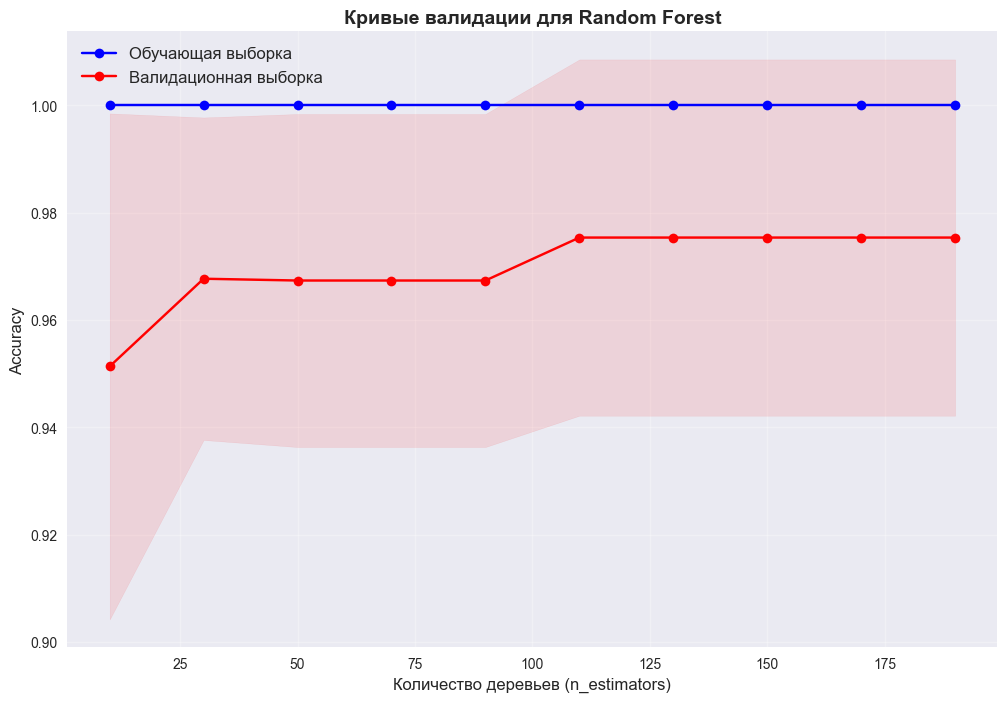

Оптимальное количество деревьев: 110
Максимальная точность валидации: 0.9753


In [36]:
# TODO: Постройте кривые валидации для n_estimators
n_estimators_range = np.arange(10, 201, 20)

train_scores, test_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X_train_scaled, y_train,
    param_name='n_estimators',
    param_range=n_estimators_range,
    cv=5, scoring='accuracy', n_jobs=-1
)

# Вычисление средних и стандартных отклонений
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

# TODO: Визуализация кривых валидации
plt.figure(figsize=(12, 8))
plt.plot(n_estimators_range, train_mean, 'o-', color='blue', label='Обучающая выборка')
plt.fill_between(n_estimators_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(n_estimators_range, test_mean, 'o-', color='red', label='Валидационная выборка')
plt.fill_between(n_estimators_range, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')

plt.xlabel('Количество деревьев (n_estimators)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Кривые валидации для Random Forest', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Найти оптимальное количество деревьев
optimal_n_estimators = n_estimators_range[np.argmax(test_mean)]
print(f"Оптимальное количество деревьев: {optimal_n_estimators}")
print(f"Максимальная точность валидации: {test_mean.max():.4f}")

## Часть 6: Самостоятельное задание

Теперь примените полученные знания к новому датасету.

### Задание 6.1: Работа с датасетом Breast Cancer

Загрузите датасет Breast Cancer и повторите анализ.

In [37]:
# TODO: Загрузите датасет Breast Cancer
cancer_data = load_breast_cancer()
X_cancer, y_cancer = cancer_data.data, cancer_data.target

# TODO: Создайте DataFrame
cancer_df = pd.DataFrame(X_cancer, columns=cancer_data.feature_names)
cancer_df['target'] = y_cancer
cancer_df['target_name'] = [cancer_data.target_names[i] for i in y_cancer]

print("Информация о датасете Breast Cancer:")
print(f"Размер: {cancer_df.shape}")
print(f"Признаки: {len(cancer_data.feature_names)}")
print(f"Классы: {cancer_data.target_names}")
print(f"Распределение классов:\n{cancer_df['target_name'].value_counts()}")

# TODO: Подготовьте данные
X_cancer_clean = cancer_df.drop(['target', 'target_name'], axis=1)
y_cancer_clean = cancer_df['target']

X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer_clean, y_cancer_clean, test_size=0.3, random_state=42, stratify=y_cancer_clean
)

# Стандартизация
scaler_cancer = StandardScaler()
X_train_cancer_scaled = scaler_cancer.fit_transform(X_train_cancer)
X_test_cancer_scaled = scaler_cancer.transform(X_test_cancer)

print(f"\nОбучающая выборка: {X_train_cancer_scaled.shape}")
print(f"Тестовая выборка: {X_test_cancer_scaled.shape}")

Информация о датасете Breast Cancer:
Размер: (569, 32)
Признаки: 30
Классы: ['malignant' 'benign']
Распределение классов:
target_name
benign       357
malignant    212
Name: count, dtype: int64

Обучающая выборка: (398, 30)
Тестовая выборка: (171, 30)


### Задание 6.2: Ваш анализ

Проведите полный анализ датасета Breast Cancer, включая:
1. Сравнение всех ансамблевых методов
2. Настройку гиперпараметров для лучшей модели
3. Анализ важности признаков
4. Выводы и рекомендации

In [38]:
# TODO: Ваш код здесь
# Подсказка: используйте код из предыдущих заданий как основу

print("TODO: Реализуйте полный анализ датасета Breast Cancer")
print("Включите:")
print("1. Сравнение всех ансамблевых методов")
print("2. Настройку гиперпараметров")
print("3. Визуализации")
print("4. Анализ важности признаков")
print("5. Выводы")

# Начните с создания словаря моделей
models_cancer = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    # Добавьте другие модели
}

# Ваш анализ...

TODO: Реализуйте полный анализ датасета Breast Cancer
Включите:
1. Сравнение всех ансамблевых методов
2. Настройку гиперпараметров
3. Визуализации
4. Анализ важности признаков
5. Выводы


## Заключение и выводы

### Что мы изучили:

1. **Bagging методы:**
   - Bootstrap Aggregating снижает дисперсию
   - Random Forest добавляет случайность в выбор признаков
   - Extra Trees использует случайные разбиения

2. **Boosting методы:**
   - AdaBoost фокусируется на ошибках предыдущих моделей
   - Gradient Boosting оптимизирует функцию потерь
   - XGBoost добавляет регуляризацию и оптимизации

3. **Практические навыки:**
   - Сравнение производительности моделей
   - Настройка гиперпараметров с GridSearchCV
   - Анализ важности признаков
   - Построение кривых обучения и валидации

### Ключевые выводы:

- Ансамблевые методы почти всегда превосходят одиночные модели
- Random Forest - отличный выбор для начала
- Boosting методы могут достигать высокой точности, но требуют осторожной настройки
- Важность признаков помогает понять данные
- Кросс-валидация критически важна для оценки моделей